<a href="https://colab.research.google.com/github/guney1/LSTM_Stock_Prediction/blob/master/LSTM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Get the required libaries

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12743202991226456082
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4195575339373167767
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14681425559768666888
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9963887416640425299
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from functools import partial
import talib
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# Get the Data and Process it

In [0]:
start_date = '1970-12-31'
end_date = '2019-06-09'
#end_date = '2019-04-12'
df = web.DataReader('AAPL', 'yahoo', start_date, end_date)
df = df.drop(["Adj Close"], axis=1)
df["mid"] = (df["High"]+df["Low"])/2
backtest = df.copy()
backtest2 = backtest['2017-10-31':'2019-06-05']


In [0]:

df["return_log"] = df["mid"].pct_change(1)
# Smooth data with Double exponential moving average
df["Close"] = talib.DEMA(np.array(df["Close"]), timeperiod=3)
df["High"] = talib.DEMA(np.array(df["High"]), timeperiod=3)
df["Low"] = talib.DEMA(np.array(df["Low"]), timeperiod=3)
df["Open"] = talib.DEMA(np.array(df["Open"]), timeperiod=3)
# Add tech indicators
df["dema"] = talib.DEMA(np.array(df["Close"]), timeperiod=30) #Double Exponential Moving Average
df["kama"] = talib.KAMA(np.array(df["Close"]), timeperiod=30) # Kaufman Adaptive Moving Average
df["trima"] = talib.TRIMA(np.array(df["Close"]), timeperiod=30) # Triple exponential
df["WMA"] = talib.WMA(np.array(df["Close"]), timeperiod=30) # Weighted moving average
df["adx"] = talib.ADX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["adxr"] = talib.ADXR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["apo"] = talib.APO(np.array(df["Close"]), fastperiod=12, slowperiod=26)
df["aroondown"], df["aroonup"] = talib.AROON(np.array(df["High"]), np.array(df["Low"]), timeperiod=14) 
df["aroonosc"] = talib.AROONOSC(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["bop"] = talib.BOP(np.array(df["Open"]), np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"])) 
df["cmo"] = talib.CMO(np.array(df["Close"]), timeperiod=14) 
df["dx"] = talib.DX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["mfi"] = talib.MFI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), np.array(df["Volume"]), timeperiod=14) 
df["minus_di"] = talib.MINUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["minus_dm"] = talib.MINUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["plus_di"] = talib.PLUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["plus_dm"] = talib.PLUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["ppo"] = talib.PPO(np.array(df["Close"]), fastperiod=10, slowperiod=20)
df["rsi_14"] = talib.RSI(np.array(df["Close"]), timeperiod=14)
df["slowk"], df["slowd"] = talib.STOCH(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(np.array(df["Close"]), fastperiod=12, slowperiod=26, signalperiod=9)
df["cci"] = talib.CCI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["mom20"] = talib.MOM(np.array(df["Close"]), timeperiod=20)
df["mom10"] = talib.MOM(np.array(df["Close"]), timeperiod=10)
df["ma20"] = talib.SMA(np.array(df["Close"]), timeperiod=20)
df["ma10"] = talib.SMA(np.array(df["Close"]), timeperiod=10)
df["roc"] = talib.ROC(np.array(df["Close"]), timeperiod=10)
df["ult"] = talib.ULTOSC(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod1=7, timeperiod2=14, timeperiod3=28)
df["will"] = talib.WILLR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["return_1df"] = df["return_log"].shift(-1)


In [0]:
df = df.dropna()
# Create a copy of data set for denoising
df_ = df.copy()
df_ = df_.drop(["return_1df"], axis=1)

In [0]:
df = df.iloc[140:]
df_ = df_.iloc[140:]

In [0]:
# Train valid test split
train_df_ = df_.iloc[:9000]
test_df_ = df_.iloc[9000:9200]
train_df = df.iloc[:9000]
test_df = df.iloc[9000:9200]
out_of_sample = df['2017-10-31':'2019-06-05']
out_of_sample_ = df_['2017-10-31':'2019-06-05']

# Seperate features and target for training data
train_data_X = np.array(train_df_.values)
train_data_y = np.array(train_df["return_1df"].values)
# Seperate for valid data
test_data_X = np.array(test_df_.values)
test_data_y = np.array(test_df["return_1df"].values)
# Seperate for test data
X_out_sample = np.array(out_of_sample_.values)
y_out_sample = np.array(out_of_sample["return_1df"].values)
backtest_X = np.array(backtest_.values)
backtest_y = np.array(backtest["return_1df"].values)



In [0]:

# Windowized normalization
smoothing_window_size = 600

scaler_min = MinMaxScaler()
for di in range(0,9000,smoothing_window_size):
    scaler_min.fit(train_data_X[di:di+smoothing_window_size,:])
    train_data_X[di:di+smoothing_window_size,:] = scaler_min.transform(train_data_X[di:di+smoothing_window_size,:])
    
test_data_X = scaler_min.transform(test_data_X)
X_out_sample = scaler_min.transform(X_out_sample)
backtest_X = scaler_min.transform(backtest_X)

# Model Construction

In [0]:
X_train = train_data_X
y_train = train_data_y
X_test = test_data_X
y_test = test_data_y
X_out_sample = X_out_sample
y_out_sample = y_out_sample


In [0]:
n_steps = 20
n_inputs = X_train.shape[1]
num_nodes = 200
n_layers = 2
n_outputs = 1
# Reshape it for LSTM
X_test = X_test.reshape((-1, n_steps, n_inputs))
y_test = y_test.reshape((-1, n_steps, n_outputs))    
X_out_sample = X_out_sample.reshape((-1, n_steps, n_inputs))
y_out_sample = y_out_sample.reshape((-1, n_steps, n_outputs))
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
# initializers
he_init = tf.contrib.layers.variance_scaling_initializer()
he_init1 = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN', uniform=True)
he_init2 = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_AVG', uniform=True)
he_init3 = tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_AVG', uniform=False)
# Activations
tanh = tf.nn.tanh
elu = tf.nn.elu
leaky_relu = tf.nn.leaky_relu
# Construction
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
keep_prob = tf.placeholder_with_default(1.0, shape=())



cells = [tf.nn.rnn_cell.LSTMCell(num_units=num_nodes, use_peepholes=True, activation=tanh, initializer=he_init2) for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob) for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)


rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs_ = tf.reshape(rnn_outputs, [-1, num_nodes])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs_, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])


learning_rate = 0.005


loss = tf.reduce_mean(tf.square(outputs - y))

#Gradient clip for exploding gradient
threshold = 0.3
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs) # then apply it, normally minimize funtion do it all



init = tf.global_variables_initializer()
saver = tf.train.Saver()

train_keep_prob = 0.7
max_checks_without_progress = 40
checks_without_progress = 0
best_loss = np.infty
n_iterations = 200
batch_size = 180
mse_train = []
mse_test = []
mse_out_ = []

In [0]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# Model Execution

In [0]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            y_batch = y_batch.reshape((-1, n_steps, n_outputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        mse = loss.eval(feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})
        mse_ = loss.eval(feed_dict={X: X_test, y: y_test, keep_prob: train_keep_prob})
        mse_out = loss.eval(feed_dict={X: X_out_sample, y: y_out_sample})
        mse_train.append(mse)
        mse_test.append(mse_)
        mse_out_.append(mse_out)
        print(iteration, "\tMSE:", mse, " MSE_TEST", mse_, " MSE_out", mse_out)
        if mse_ < best_loss: # adding stop loss
            save_path = saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_10")
            best_loss = mse_
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break      


0 	MSE: 0.004322723  MSE_TEST 0.007863303  MSE_out 0.002212199
1 	MSE: 0.0012051136  MSE_TEST 0.0013803846  MSE_out 0.0013265337
2 	MSE: 0.0023512435  MSE_TEST 0.0028325173  MSE_out 0.0015164185
3 	MSE: 0.0028425492  MSE_TEST 0.0035260678  MSE_out 0.0033500122
4 	MSE: 0.015565289  MSE_TEST 0.020855553  MSE_out 0.021128364
5 	MSE: 0.0007517316  MSE_TEST 0.0003053682  MSE_out 0.00025950652
6 	MSE: 0.3391368  MSE_TEST 0.58988607  MSE_out 0.62898886
7 	MSE: 0.0011378011  MSE_TEST 0.0007790602  MSE_out 0.00077684375
8 	MSE: 0.0011455406  MSE_TEST 0.00023346128  MSE_out 0.00028662293
9 	MSE: 0.0005763974  MSE_TEST 0.00019978652  MSE_out 0.00027564567
10 	MSE: 0.0006071552  MSE_TEST 0.00011710033  MSE_out 0.00022297596
11 	MSE: 0.00043027074  MSE_TEST 0.00011168927  MSE_out 0.00022599775
12 	MSE: 0.00054063863  MSE_TEST 0.0001600193  MSE_out 0.00026664865
13 	MSE: 0.00039096258  MSE_TEST 0.00020247014  MSE_out 0.00031130685
14 	MSE: 0.0004683411  MSE_TEST 0.0001911197  MSE_out 0.00027396472
1

# Prediction

In [0]:
X_out_sample = X_out_sample.reshape((-1, n_steps, n_inputs))
y_out_sample = y_out_sample.reshape((-1, n_steps, n_outputs))
backtest_X = backtest_X.reshape((-1, n_steps, n_inputs))
with tf.Session() as sess:
    saver.restore(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final")
    #saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final")
    X_new = X_test
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    X_new_ = X_out_sample
    y_pred_out = sess.run(outputs, feed_dict={X: X_new_})

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final


# Results

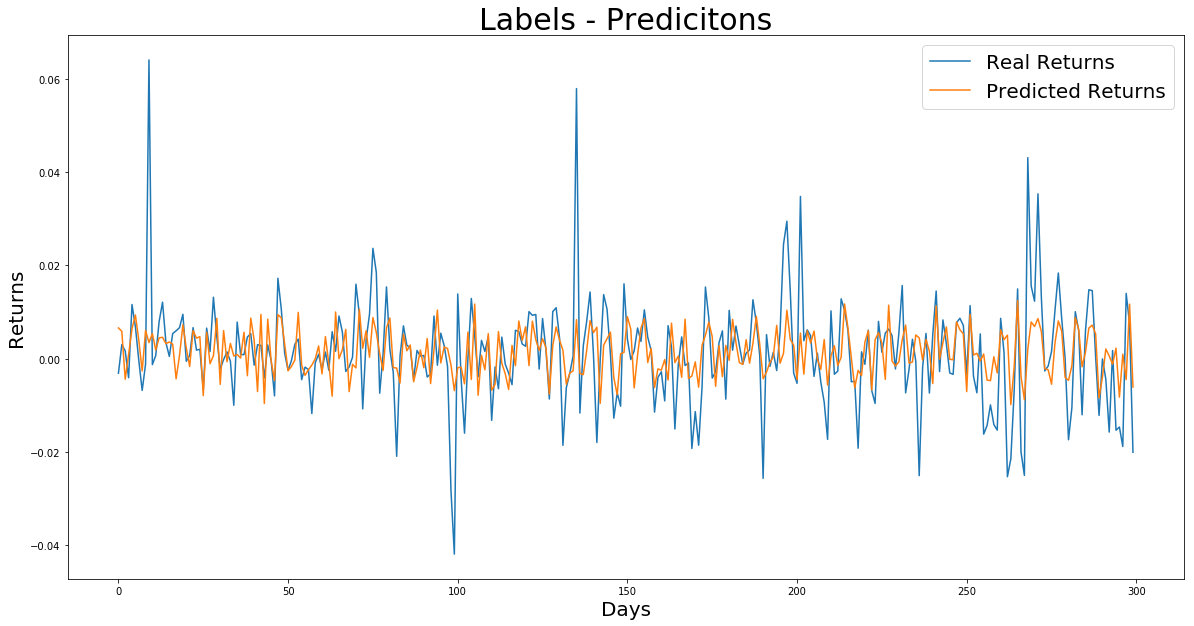

In [0]:
plt.figure(figsize=(20,10))
plt.title("Labels - Predicitons", size=30)
plt.xlabel('Days', size=20)
plt.ylabel('Returns', size=20)
plt.plot(y_test.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_pred.reshape((-1, 1)), label = "Predicted Returns")
plt.legend(prop={'size': 20})
plt.savefig("/content/gdrive/My Drive/Plots/SPY Test Preds")

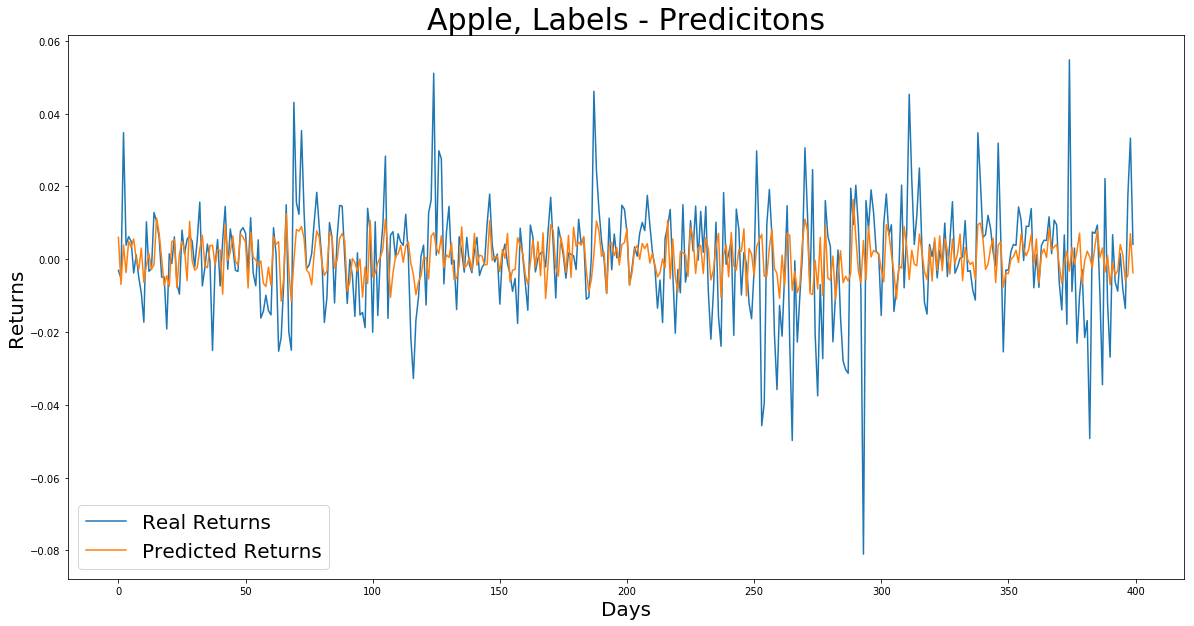

In [0]:
plt.figure(figsize=(20,10))
plt.title("Apple, Labels - Predicitons", size=30)
plt.xlabel('Days', size=20)
plt.ylabel('Returns', size=20)
plt.plot(y_out_sample.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_pred_out.reshape((-1, 1)), label = "Predicted Returns")
plt.legend(prop={'size': 20})
plt.savefig("/content/gdrive/My Drive/Plots/Apple Test Preds")

In [0]:
comparison_change = pd.concat([pd.DataFrame(y_out_sample.reshape((-1, 1))), 
                        pd.DataFrame(y_pred_out.reshape((-1, 1)))], axis=1)

# Calculate the pct change    
comparison_change.columns = ["True", "Pred"]
# Tranform regression predictions to classification
test = []
for a in comparison_change["True"]:
    if a >= 0:
        test.append(1)
    else:
        test.append(0)

pred = []
for a in comparison_change["Pred"]:
    if a >= 0:
        pred.append(1)
    else:
        pred.append(0)

# Classification Report
accuracy_score(test, pred)

0.675

In [0]:
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.62      0.67      0.64       177
           1       0.72      0.68      0.70       223

    accuracy                           0.68       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.68      0.68      0.68       400



In [0]:
y_out_sample = y_out_sample.reshape(-1, 1)
y_pred_out = y_pred_out.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

In [0]:
mean_squared_error(y_out_sample, y_pred_out)

0.00013030403145704376

In [0]:
mean_absolute_error(y_out_sample, y_pred_out)

0.00820550870495415

In [0]:
!mkdir "/content/gdrive/My Drive/Plots/"

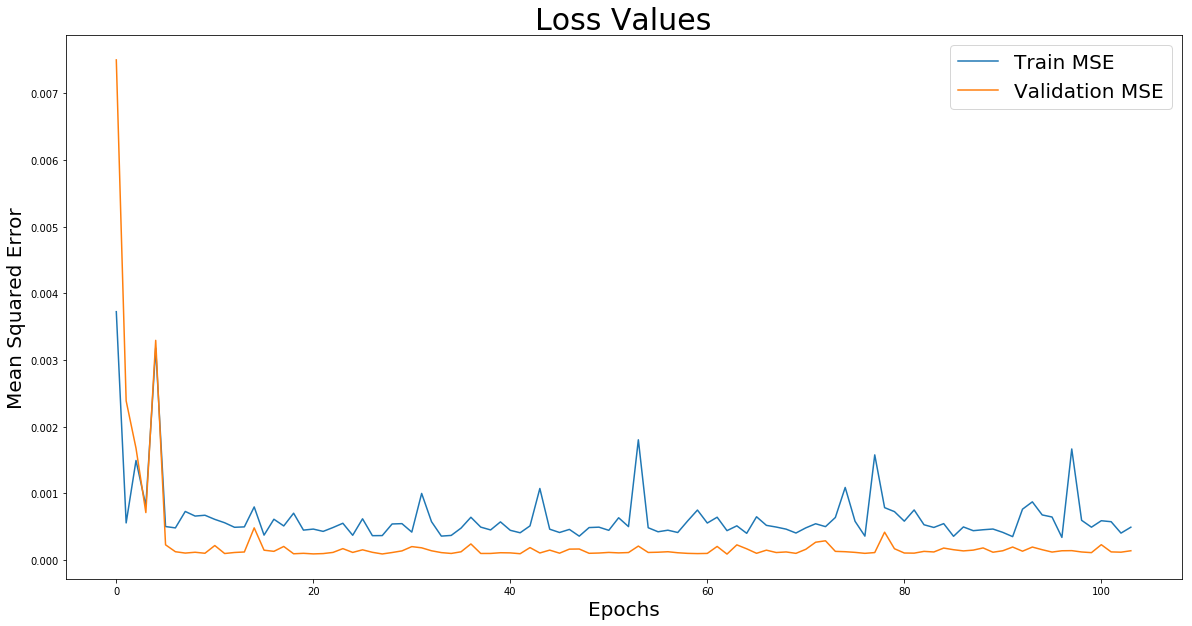

In [0]:
plt.figure(figsize=(20,10))
plt.title("Loss Values", size=30)
plt.xlabel('Epochs', size=20)
plt.ylabel('Mean Squared Error', size=20)
plt.plot(mse_train, label="Train MSE")
plt.plot(mse_test, label="Validation MSE")
#plt.plot(mse_out_, label="Test MSE")
plt.legend(prop={'size': 20})
plt.savefig("/content/gdrive/My Drive/Plots/Loss Values")



# Backtest

In [0]:
raw_prediction = y_pred_out.reshape(-1, 1)
Suggestion = []
percentChange = []


for d in range(len(raw_prediction)):
    percentChange.append(float((raw_prediction[d])))


    
for n in range(len(percentChange)):
    if (backtest2["mid"][n]*(1+percentChange[n]))>backtest2["Close"][n]:
        Suggestion.append(1) # buy if next day prediction higher
    elif (backtest2["mid"][n]*(1+percentChange[n]))<backtest2["Close"][n]:
        Suggestion.append(-1) # sell if next day prediction lower
    else:
        Suggestion.append(0) # hold otherwise

In [0]:
PurchaseHistory=[]
BuyPoints =  [[], []]
SellPoints = [[], []]
bought = False
for i in range(0, len(backtest2)-1):
    if Suggestion[i] == 1 and not bought:
        PurchaseHistory.append(["Buy: ", backtest2["Close"][i], i])
        BuyPoints[0].append(backtest2["Close"][i])
        BuyPoints[1].append(i)
        bought = True
    if Suggestion[i] == -1 and bought:
        PurchaseHistory.append(["Sell:", backtest2["Close"][i], i])
        SellPoints[0].append(backtest2["Close"][i])
        SellPoints[1].append(i)        
        bought = False
if len(PurchaseHistory)%2 != 0:
    PurchaseHistory.pop()
    BuyPoints[0].pop()
    BuyPoints[1].pop() 

In [0]:
Profit = 0
for purchase in range(1, len(PurchaseHistory)+1, 2):
    MoneyMade = (PurchaseHistory[purchase][1] - PurchaseHistory[purchase-1][1])
    Profit += MoneyMade

print('$'+ str(round(Profit, 2)))


$64.71


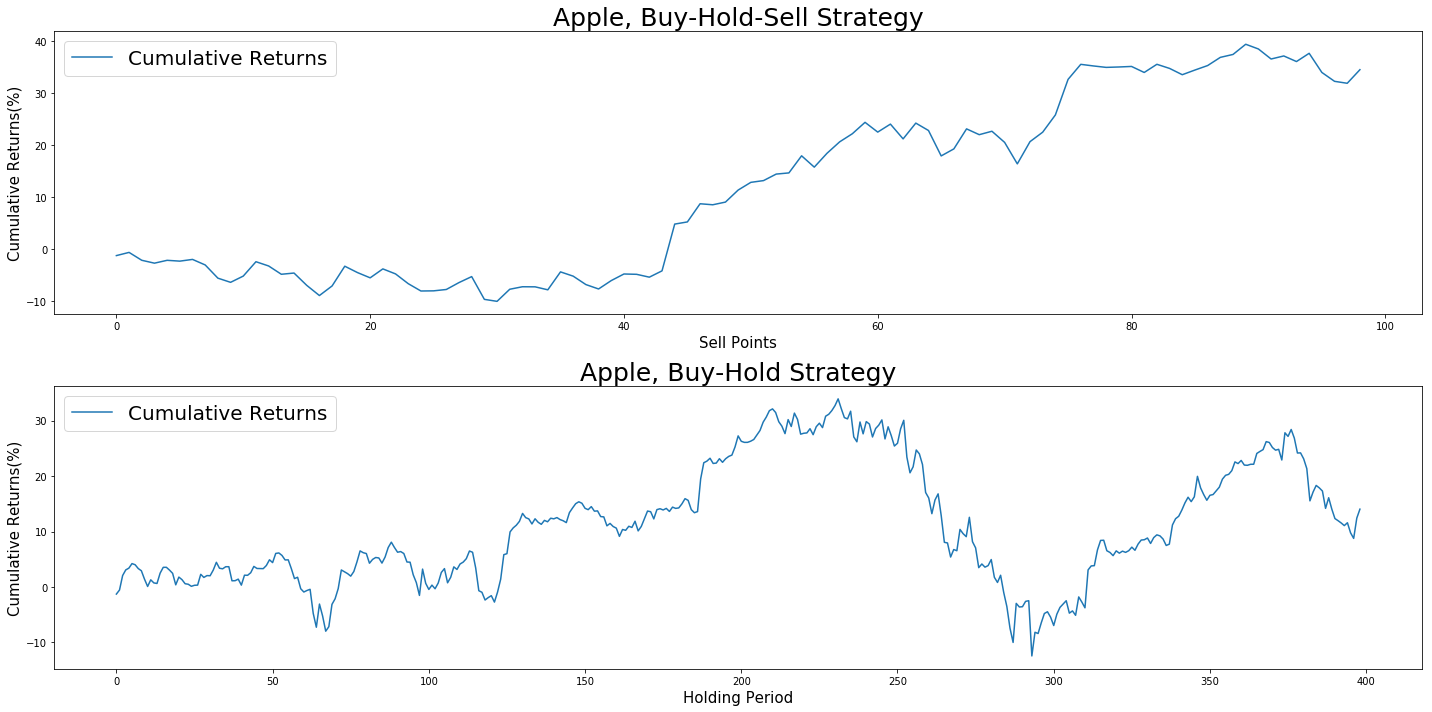

In [0]:
Profit_cum = []
for purchase in range(1, len(PurchaseHistory), 2):
    MoneyMade = (PurchaseHistory[purchase][1] - PurchaseHistory[purchase-1][1])/PurchaseHistory[purchase-1][1]*100
    Profit_cum.append(MoneyMade)
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.title("Apple, Buy-Hold-Sell Strategy", size=25)
plt.ylabel("Cumulative Returns(%)", size=15)
plt.xlabel("Sell Points", size=15)
plt.plot(np.array(Profit_cum).cumsum(), label = "Cumulative Returns")
plt.legend(prop={'size': 20})
plt.subplot(2, 1, 2)
plt.title("Apple, Buy-Hold Strategy", size=25)
plt.xlabel("Holding Period", size=15)
plt.ylabel("Cumulative Returns(%)", size=15)
plt.plot(np.array(Profit_stock).cumsum(), label="Cumulative Returns")
plt.legend(prop={'size': 20})
plt.tight_layout()
plt.savefig("/content/gdrive/My Drive/Plots/Apple Cum Returns Comparison")

300

In [0]:
Profit_stock = []
for purchase in range(1, len(backtest2)):
    MoneyMade = (backtest2["Close"][purchase] - backtest2["Close"][purchase-1])*100/backtest2["Close"][purchase-1]
    Profit_stock.append(MoneyMade)

np.array(Profit_stock).cumsum()

In [0]:
np.array(Profit_cum).cumsum()

In [0]:
# Total ROI
MinimumRequiredCapital = BuyPoints[0][0]
ROI = Profit / MinimumRequiredCapital * 100
print("Return on Investment:", round(float(ROI), 2),"%")

Return on Investment: 38.28 %


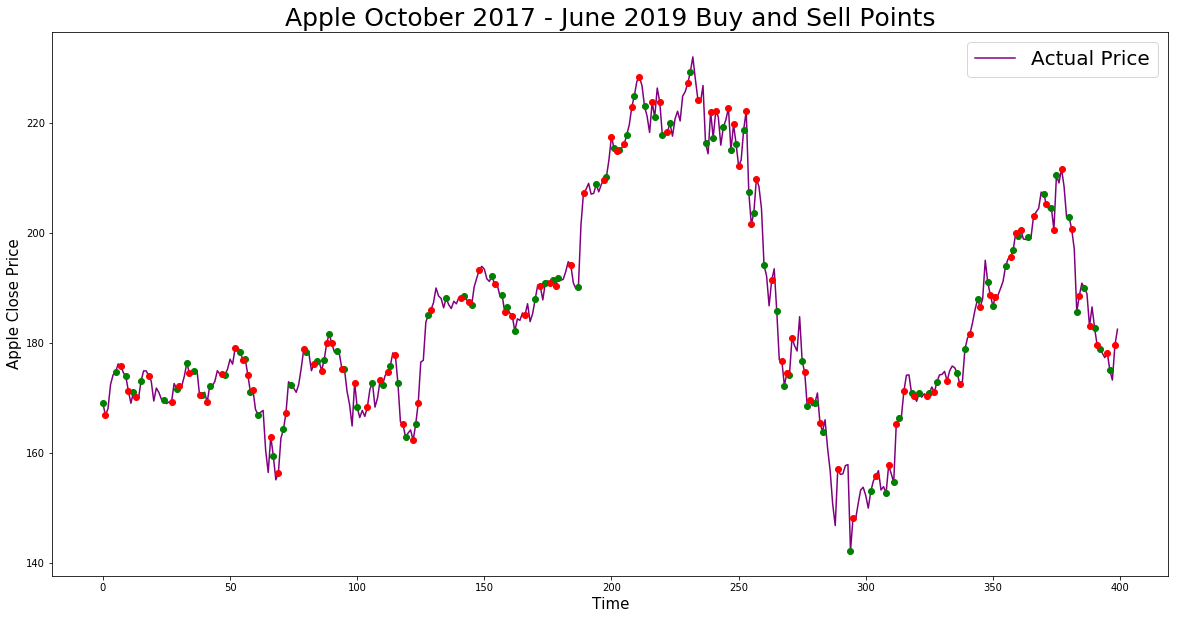

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(20,10))
plt.plot(backtest2["Close"].values, color =  'purple', label = "Actual Price")
#plt.plot(y_pred_out.reshape(-1, 1), color = 'blue', label = "Predicted Price")
plt.plot(BuyPoints[1], BuyPoints[0], "go")
plt.plot(SellPoints[1], SellPoints[0], "ro")

plt.title("Apple October 2017 - June 2019 Buy and Sell Points", size=25)
plt.xlabel('Time', size=15)
plt.ylabel('Apple Close Price', size=15)
plt.legend(prop={'size': 20})
plt.show()
plt.savefig("/content/gdrive/My Drive/Plots/Apple buy-sell points")

# Test of the model on global data, SP

In [0]:

start_date = '1970-12-31'
end_date = '2019-06-06'
df = web.DataReader('SPY', 'yahoo', start_date, end_date)
df = df.drop(["Adj Close"], axis=1)
df["mid"] = (df["High"]+df["Low"])/2
df["return_log"] = df["mid"].pct_change(1)
df_backtest = df.copy()
df_backtest = df['2017-10-31':'2019-06-05']
#backtest_sp = backtest_sp['2018-03-28':'2019-06-06']
# Smooth data with Double exponential moving average
df["Close"] = talib.DEMA(np.array(df["Close"]), timeperiod=3)
df["High"] = talib.DEMA(np.array(df["High"]), timeperiod=3)
df["Low"] = talib.DEMA(np.array(df["Low"]), timeperiod=3)
df["Open"] = talib.DEMA(np.array(df["Open"]), timeperiod=3)
# Add tech indicators
df["dema"] = talib.DEMA(np.array(df["Close"]), timeperiod=30) #Double Exponential Moving Average
df["kama"] = talib.KAMA(np.array(df["Close"]), timeperiod=30) # Kaufman Adaptive Moving Average
df["trima"] = talib.TRIMA(np.array(df["Close"]), timeperiod=30) # Triple exponential
df["WMA"] = talib.WMA(np.array(df["Close"]), timeperiod=30) # Weighted moving average
df["adx"] = talib.ADX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["adxr"] = talib.ADXR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["apo"] = talib.APO(np.array(df["Close"]), fastperiod=12, slowperiod=26)
df["aroondown"], df["aroonup"] = talib.AROON(np.array(df["High"]), np.array(df["Low"]), timeperiod=14) 
df["aroonosc"] = talib.AROONOSC(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["bop"] = talib.BOP(np.array(df["Open"]), np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"])) 
df["cmo"] = talib.CMO(np.array(df["Close"]), timeperiod=14) 
df["dx"] = talib.DX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["mfi"] = talib.MFI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), np.array(df["Volume"]), timeperiod=14) 
df["minus_di"] = talib.MINUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["minus_dm"] = talib.MINUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["plus_di"] = talib.PLUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["plus_dm"] = talib.PLUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["ppo"] = talib.PPO(np.array(df["Close"]), fastperiod=10, slowperiod=20)
df["rsi"] = talib.RSI(np.array(df["Close"]), timeperiod=14)
df["slowk"], df["slowd"] = talib.STOCH(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(np.array(df["Close"]), fastperiod=12, slowperiod=26, signalperiod=9)
df["cci"] = talib.CCI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["mom20"] = talib.MOM(np.array(df["Close"]), timeperiod=20)
df["mom10"] = talib.MOM(np.array(df["Close"]), timeperiod=10)
df["ma20"] = talib.SMA(np.array(df["Close"]), timeperiod=20)
df["ma10"] = talib.SMA(np.array(df["Close"]), timeperiod=10)
df["roc"] = talib.ROC(np.array(df["Close"]), timeperiod=10)
df["ult"] = talib.ULTOSC(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod1=7, timeperiod2=14, timeperiod3=28)
df["will"] = talib.WILLR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["return_1df"] = df["return_log"].shift(-1)



In [0]:
df = df.dropna()

In [0]:
df = df.iloc[73:]
df_ = df_.iloc[73:]
len(df)

6500

In [0]:
len(df['2017-10-31':'2019-06-05'])

400

In [0]:
df = df.dropna()
# Create a copy of data set for denoising
df_ = df.copy()
df_ = df_.drop(["return_1df"], axis=1)

df_train = df.iloc[:6000]
df_train_ = df_.iloc[:6000]
df_valid = df.iloc[6000:6200]
df_valid_ = df_.iloc[6000:6200]
df_test = df['2017-10-31':'2019-06-05']
df_test_ = df_['2017-10-31':'2019-06-05']

train_X = np.array(df_train_.values)
train_y = np.array(df_train["return_1df"].values)
valid_X = np.array(df_valid_.values)
valid_y = np.array(df_valid["return_1df"].values)
test_X = np.array(df_test_.values)
test_y = np.array(df_test["return_1df"].values)

In [0]:
smoothing_window_size = 600

scaler_min = MinMaxScaler()
for di in range(0,6000,smoothing_window_size):
    scaler_min.fit(train_X[di:di+smoothing_window_size,:])
    train_X[di:di+smoothing_window_size,:] = scaler_min.transform(train_X[di:di+smoothing_window_size,:])
    
test_X = scaler_min.transform(test_X)

In [0]:
valid_X = valid_X.reshape(-1, n_steps, 40)
test_X = test_X.reshape(-1, n_steps, 40)

In [0]:
with tf.Session() as sess:
    saver.restore(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final")
    #saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_5")
    y_valid_pred = sess.run(outputs, feed_dict={X: valid_X})
    y_test_pred = sess.run(outputs, feed_dict={X: test_X})

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final


In [0]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.5)
    plt.plot(mean, color_mean)

In [0]:
ub0 = valid_y.reshape((-1, )) + np.std(valid_y.reshape((-1, )))
lb0 = valid_y.reshape((-1, )) - np.std(valid_y.reshape((-1, )))
ub1 = y_valid_pred.reshape((-1, )) + np.std(y_valid_pred.reshape((-1, )))
lb1 = y_valid_pred.reshape((-1, )) - np.std(y_valid_pred.reshape((-1, )))


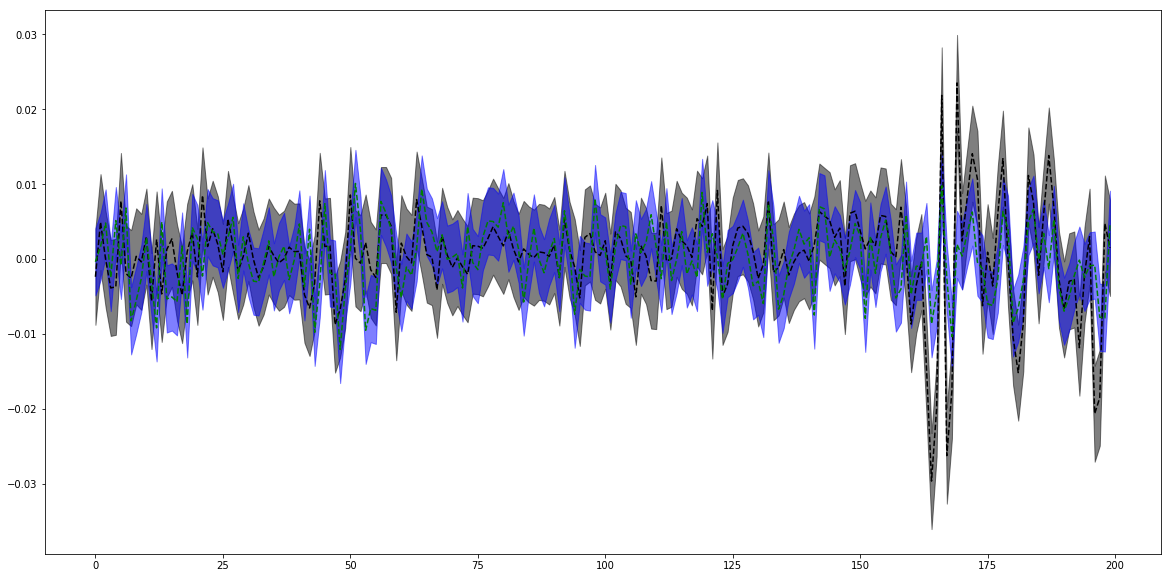

In [0]:
plt.figure(figsize=(20,10))
plot_mean_and_CI(valid_y.reshape((-1, )), ub0, lb0, color_mean='k--', color_shading='k')
plot_mean_and_CI(y_valid_pred.reshape((-1, )), ub1, lb1, color_mean='g--', color_shading='b')

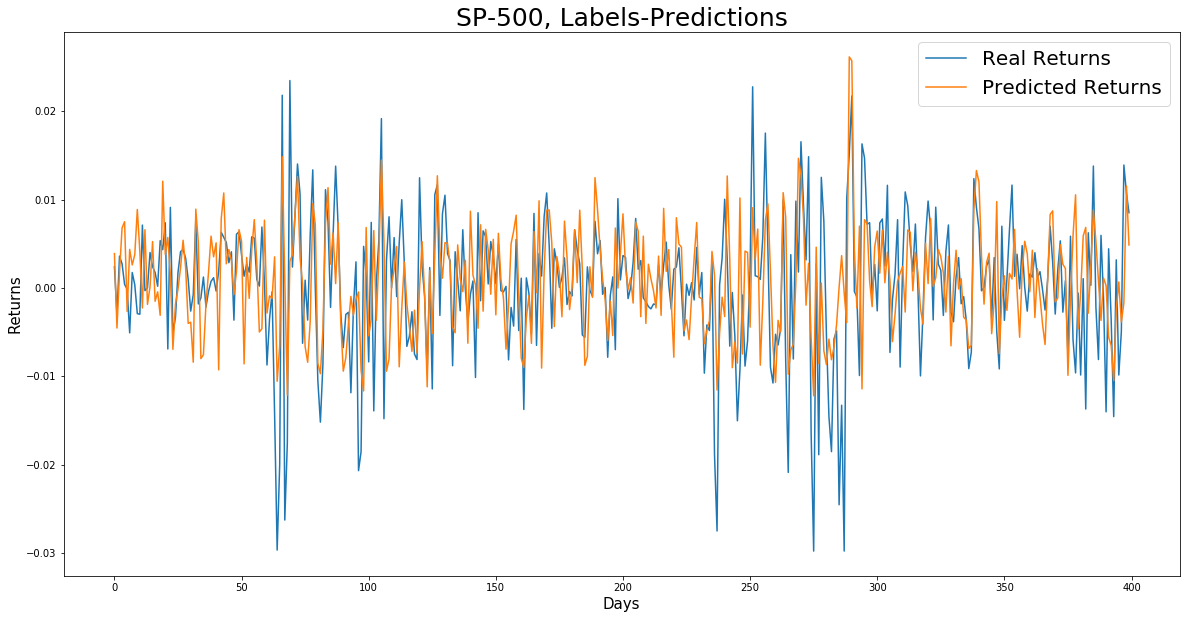

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(20,10))
plt.plot(test_y.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_test_pred.reshape((-1, 1)), label = "Predicted Returns")
plt.title("SP-500, Labels-Predictions", size=25)
plt.xlabel('Days', size=15)
plt.ylabel('Returns', size=15)
plt.legend(prop={'size': 20})
plt.show()
plt.savefig("/content/gdrive/My Drive/Plots/SP Predictions")

In [0]:
mean_squared_error(valid_y.reshape(-1, 1), y_valid_pred.reshape(-1, 1))

3.690574262572967e-05

In [0]:
mean_absolute_error(valid_y.reshape(-1, 1), y_valid_pred.reshape(-1, 1))

0.0053217254867586996

In [0]:
comparison_change_spy = pd.concat([pd.DataFrame(test_y.reshape((-1, 1))), 
                        pd.DataFrame(y_test_pred.reshape((-1, 1)))], axis=1)

# Calculate the pct change    
comparison_change_spy.columns = ["True", "Pred"]
# Tranform regression predictions to classification
test = []
for a in comparison_change_spy["True"]:
    if a >= 0:
        test.append(1)
    else:
        test.append(0)

pred = []
for a in comparison_change_spy["Pred"]:
    if a >= 0:
        pred.append(1)
    else:
        pred.append(0)

# Classification Report
accuracy_score(test, pred)

0.6475

In [0]:
# Scores on scap index, better than expected, probably it will perform better on SP ETF or large cap index
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.58      0.63      0.61       172
           1       0.70      0.66      0.68       228

    accuracy                           0.65       400
   macro avg       0.64      0.65      0.64       400
weighted avg       0.65      0.65      0.65       400



In [0]:
raw_prediction = y_test_pred.reshape(-1, 1)
Suggestion = []
percentChange = []


for d in range(len(raw_prediction)):
    percentChange.append(float((raw_prediction[d])))


    
for n in range(len(percentChange)):
    if (df_backtest["mid"][n]*(1+percentChange[n]))>df_backtest["Close"][n]:
        Suggestion.append(1) # buy if next day prediction higher
    elif (df_backtest["mid"][n]*(1+percentChange[n]))<df_backtest["Close"][n]:
        Suggestion.append(-1) # sell if next day prediction lower
    else:
        Suggestion.append(0) # hold otherwise

In [0]:
PurchaseHistory=[]
BuyPoints =  [[], []]
SellPoints = [[], []]
bought = False
for i in range(0, len(df_backtest)-1):
    if Suggestion[i] == 1 and not bought:
        PurchaseHistory.append(["Buy: ", df_backtest["Close"][i], i])
        BuyPoints[0].append(df_backtest["Close"][i])
        BuyPoints[1].append(i)
        bought = True
    if Suggestion[i] == -1 and bought:
        PurchaseHistory.append(["Sell:", df_backtest["Close"][i], i])
        SellPoints[0].append(df_backtest["Close"][i])
        SellPoints[1].append(i)        
        bought = False
if len(PurchaseHistory)%2 != 0:
    PurchaseHistory.pop()
    BuyPoints[0].pop()
    BuyPoints[1].pop() 

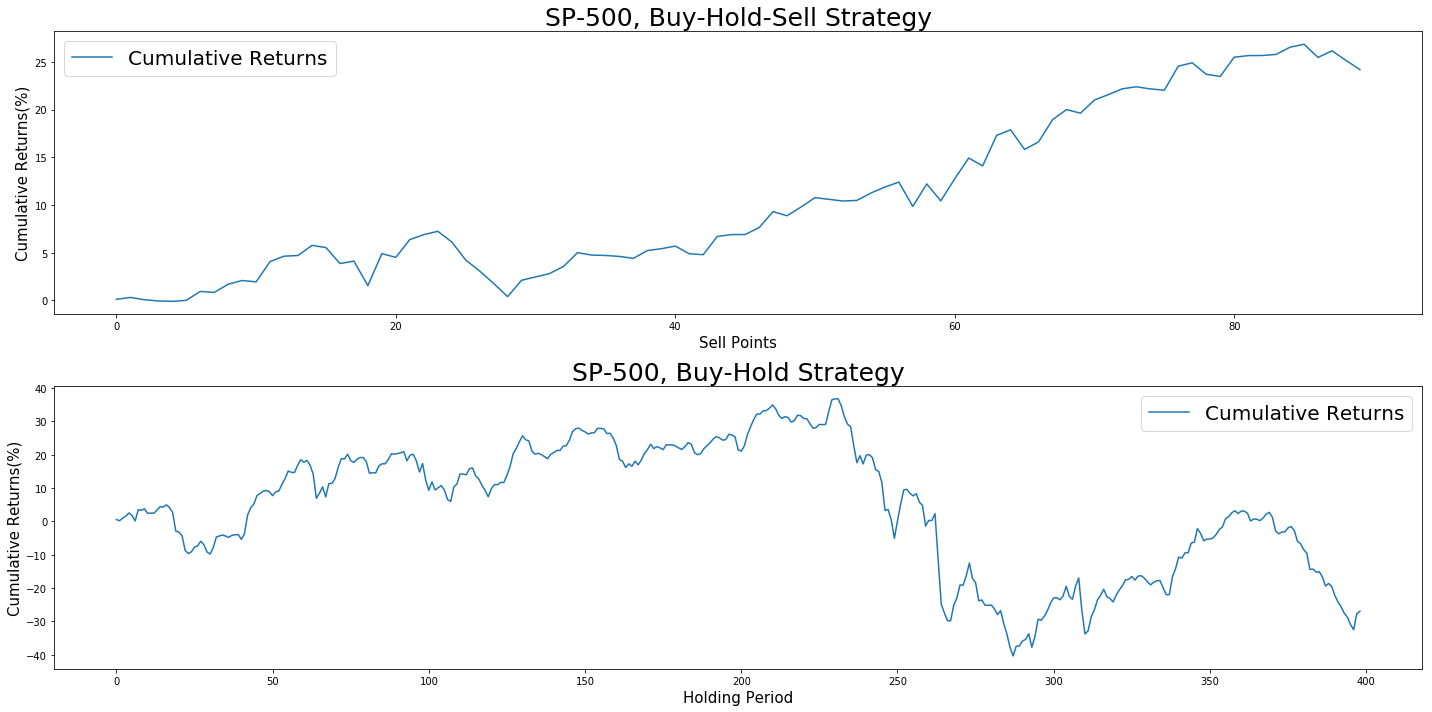

In [0]:
Profit_cum = []
for purchase in range(1, len(PurchaseHistory), 2):
    MoneyMade = (PurchaseHistory[purchase][1] - PurchaseHistory[purchase-1][1])*100/PurchaseHistory[purchase-1][1]
    Profit_cum.append(MoneyMade)
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.title("SP-500, Buy-Hold-Sell Strategy", size=25)
plt.ylabel("Cumulative Returns(%)", size=15)
plt.xlabel("Sell Points", size=15)
plt.plot(np.array(Profit_cum).cumsum(), label = "Cumulative Returns")
plt.legend(prop={'size': 20})
plt.subplot(2, 1, 2)
plt.title("SP-500, Buy-Hold Strategy", size=25)
plt.xlabel("Holding Period", size=15)
plt.ylabel("Cumulative Returns(%)", size=15)
plt.plot(np.array(Profit_stock).cumsum(), label="Cumulative Returns")
plt.legend(prop={'size': 20})
plt.tight_layout()
plt.savefig("/content/gdrive/My Drive/Plots/SP Cum Returns Comparison")

In [0]:
Profit_stock = []
for purchase in range(1, len(df_test)):
    MoneyMade = (df_backtest["Close"][purchase] - df_backtest["Close"][purchase-1])*100/df_backtest["Close"][purchase-1]
    Profit_stock.append(MoneyMade)

np.array(Profit_stock).cumsum()

In [0]:
Profit_cum = []
for purchase in range(1, len(PurchaseHistory), 2):
    MoneyMade = (PurchaseHistory[purchase][1] - PurchaseHistory[purchase-1][1])*100/PurchaseHistory[purchase-1][1]
    Profit_cum.append(MoneyMade)
np.array(Profit_cum).cumsum()[-1]

24.18564915063516

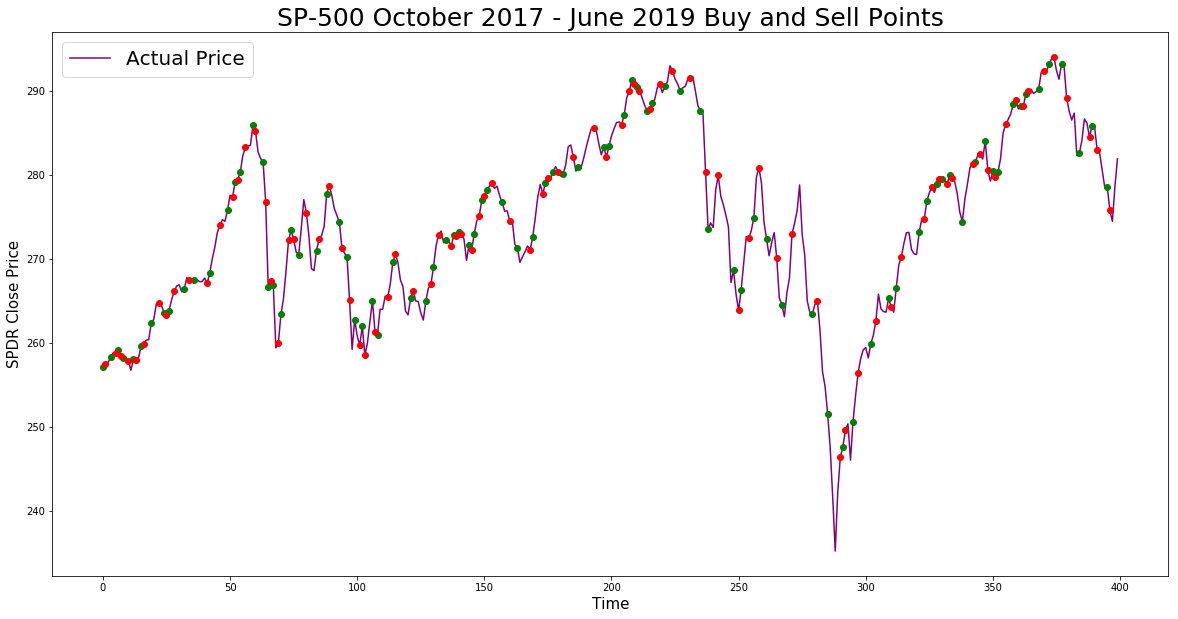

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(20,10))
plt.plot(df_backtest["Close"].values, color =  'purple', label = "Actual Price")
#plt.plot(y_pred_out.reshape(-1, 1), color = 'blue', label = "Predicted Price")
plt.plot(BuyPoints[1], BuyPoints[0], "go")
plt.plot(SellPoints[1], SellPoints[0], "ro")

plt.title("SP-500 October 2017 - June 2019 Buy and Sell Points", size=25)
plt.xlabel('Time', size=15)
plt.ylabel('SPDR Close Price', size=15)
plt.legend(prop={'size': 20})
plt.show()
plt.savefig("/content/gdrive/My Drive/Plots/SP buy-sell points")

In [0]:
start_date = '1970-12-31'
end_date = '2019-06-06'
df = web.DataReader('NVDA', 'yahoo', start_date, end_date)
df = df.drop(["Adj Close"], axis=1)
df["mid"] = (df["High"]+df["Low"])/2
df["return_log"] = df["mid"].pct_change(1)
df_backtest_nv = df.copy()
df_backtest_nv = df['2017-10-31':'2019-06-05']
#backtest_sp = backtest_sp['2018-03-28':'2019-06-06']
# Smooth data with Double exponential moving average
df["Close"] = talib.DEMA(np.array(df["Close"]), timeperiod=3)
df["High"] = talib.DEMA(np.array(df["High"]), timeperiod=3)
df["Low"] = talib.DEMA(np.array(df["Low"]), timeperiod=3)
df["Open"] = talib.DEMA(np.array(df["Open"]), timeperiod=3)
# Add tech indicators
df["dema"] = talib.DEMA(np.array(df["Close"]), timeperiod=30) #Double Exponential Moving Average
df["kama"] = talib.KAMA(np.array(df["Close"]), timeperiod=30) # Kaufman Adaptive Moving Average
df["trima"] = talib.TRIMA(np.array(df["Close"]), timeperiod=30) # Triple exponential
df["WMA"] = talib.WMA(np.array(df["Close"]), timeperiod=30) # Weighted moving average
df["adx"] = talib.ADX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["adxr"] = talib.ADXR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["apo"] = talib.APO(np.array(df["Close"]), fastperiod=12, slowperiod=26)
df["aroondown"], df["aroonup"] = talib.AROON(np.array(df["High"]), np.array(df["Low"]), timeperiod=14) 
df["aroonosc"] = talib.AROONOSC(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["bop"] = talib.BOP(np.array(df["Open"]), np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"])) 
df["cmo"] = talib.CMO(np.array(df["Close"]), timeperiod=14) 
df["dx"] = talib.DX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["mfi"] = talib.MFI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), np.array(df["Volume"]), timeperiod=14) 
df["minus_di"] = talib.MINUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["minus_dm"] = talib.MINUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["plus_di"] = talib.PLUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["plus_dm"] = talib.PLUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["ppo"] = talib.PPO(np.array(df["Close"]), fastperiod=10, slowperiod=20)
df["rsi"] = talib.RSI(np.array(df["Close"]), timeperiod=14)
df["slowk"], df["slowd"] = talib.STOCH(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(np.array(df["Close"]), fastperiod=12, slowperiod=26, signalperiod=9)
df["cci"] = talib.CCI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["mom20"] = talib.MOM(np.array(df["Close"]), timeperiod=20)
df["mom10"] = talib.MOM(np.array(df["Close"]), timeperiod=10)
df["ma20"] = talib.SMA(np.array(df["Close"]), timeperiod=20)
df["ma10"] = talib.SMA(np.array(df["Close"]), timeperiod=10)
df["roc"] = talib.ROC(np.array(df["Close"]), timeperiod=10)
df["ult"] = talib.ULTOSC(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod1=7, timeperiod2=14, timeperiod3=28)
df["will"] = talib.WILLR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["return_1df"] = df["return_log"].shift(-1)


In [0]:
df = df.dropna()
# Create a copy of data set for denoising
df_ = df.copy()
df_ = df_.drop(["return_1df"], axis=1)


In [0]:
df_ = df_.drop(["return_1df"], axis=1)


In [0]:
df = df.iloc[63:]
df_ = df_.iloc[63:]
len(df)

5000

In [0]:
len(df_test.index)

400

In [0]:


df_train = df.iloc[:4500]
df_train_ = df_.iloc[:4500]
df_valid = df.iloc[4100:4700]
df_valid_ = df_.iloc[4100:4700]
df_test = df['2017-10-31':'2019-06-05']
df_test_ = df_['2017-10-31':'2019-06-05']

train_X = np.array(df_train_.values)
train_y = np.array(df_train["return_1df"].values)
valid_X = np.array(df_valid_.values)
valid_y = np.array(df_valid["return_1df"].values)
test_X = np.array(df_test_.values)
test_y = np.array(df_test["return_1df"].values)

In [0]:
smoothing_window_size = 600

scaler_min = MinMaxScaler()
#for di in range(0,4500,smoothing_window_size):
#    scaler_min.fit(train_X[di:di+smoothing_window_size,:])
#    train_X[di:di+smoothing_window_size,:] = scaler_min.transform(train_X[di:di+smoothing_window_size,:])
scaler_min.fit(valid_X)    
test_X = scaler_min.transform(test_X)

In [0]:
valid_X = valid_X.reshape(-1, n_steps, 40)
test_X = test_X.reshape(-1, n_steps, 40)

In [0]:
with tf.Session() as sess:
    saver.restore(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final")
    #saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_5")
    y_valid_pred = sess.run(outputs, feed_dict={X: valid_X})
    y_test_pred = sess.run(outputs, feed_dict={X: test_X})

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final


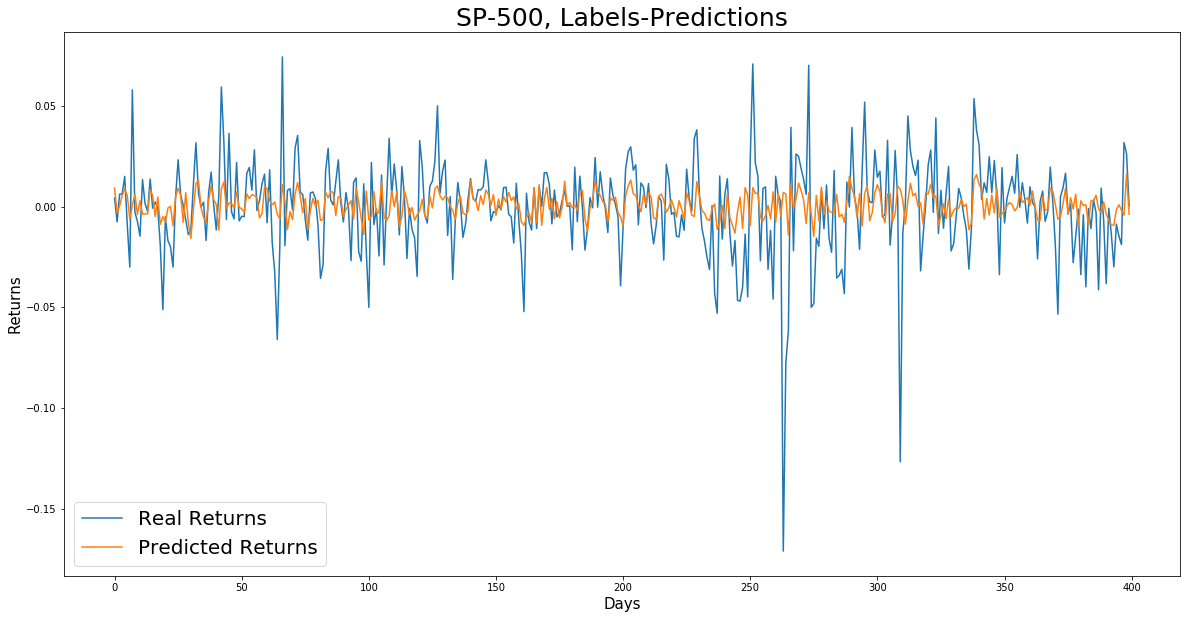

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(20,10))
plt.plot(test_y.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_test_pred.reshape((-1, 1)), label = "Predicted Returns")
plt.title("NVDIA, Labels-Predictions", size=25)
plt.xlabel('Days', size=15)
plt.ylabel('Returns', size=15)
plt.legend(prop={'size': 20})
plt.show()
plt.savefig("/content/gdrive/My Drive/Plots/SP Predictions")

In [0]:
raw_prediction = y_test_pred.reshape(-1, 1)
Suggestion = []
percentChange = []


for d in range(len(raw_prediction)):
    percentChange.append(float((raw_prediction[d])))


    
for n in range(len(percentChange)):
    if (df_backtest_nv["mid"][n]*(1+percentChange[n]))>df_backtest_nv["Close"][n]:
        Suggestion.append(1) # buy if next day prediction higher
    elif (df_backtest_nv["mid"][n]*(1+percentChange[n]))<df_backtest_nv["Close"][n]:
        Suggestion.append(-1) # sell if next day prediction lower
    else:
        Suggestion.append(0) # hold otherwise

In [0]:
PurchaseHistory=[]
BuyPoints =  [[], []]
SellPoints = [[], []]
bought = False
for i in range(0, len(df_backtest_nv)-1):
    if Suggestion[i] == 1 and not bought:
        PurchaseHistory.append(["Buy: ", df_backtest_nv["Close"][i], i])
        BuyPoints[0].append(df_backtest_nv["Close"][i])
        BuyPoints[1].append(i)
        bought = True
    if Suggestion[i] == -1 and bought:
        PurchaseHistory.append(["Sell:", df_backtest_nv["Close"][i], i])
        SellPoints[0].append(df_backtest_nv["Close"][i])
        SellPoints[1].append(i)        
        bought = False
if len(PurchaseHistory)%2 != 0:
    PurchaseHistory.pop()
    BuyPoints[0].pop()
    BuyPoints[1].pop() 

In [0]:
Profit_cum = []
for purchase in range(1, len(PurchaseHistory), 2):
    MoneyMade = (PurchaseHistory[purchase][1] - PurchaseHistory[purchase-1][1])/PurchaseHistory[purchase-1][1]*100
    Profit_cum.append(MoneyMade)
np.array(Profit_cum).cumsum()

In [0]:
Profit_stock = []
for purchase in range(1, len(df_backtest)):
    MoneyMade = (df_backtest_nv["Close"][purchase] - df_backtest_nv["Close"][purchase-1])*100/df_backtest_nv["Close"][purchase-1]
    Profit_stock.append(MoneyMade)

np.array(Profit_stock).cumsum()

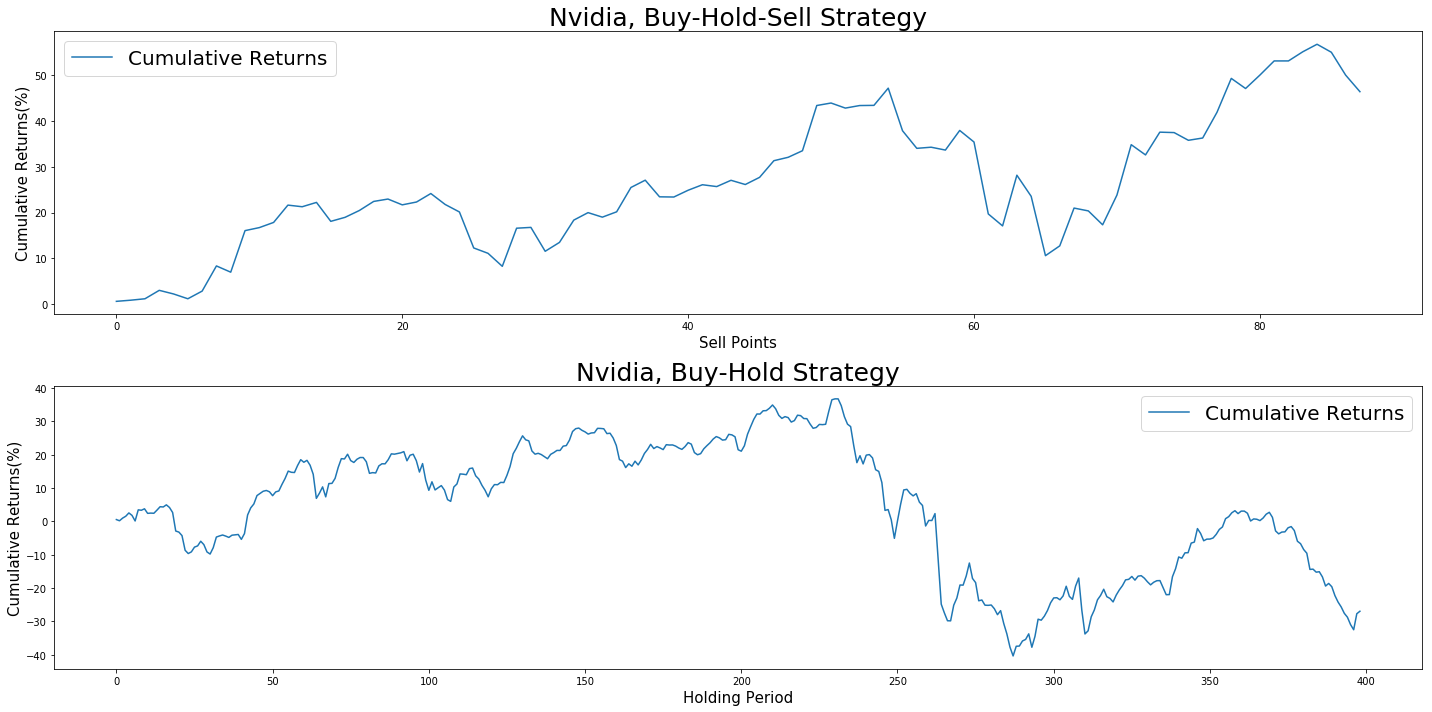

In [0]:

plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.title("Nvidia, Buy-Hold-Sell Strategy", size=25)
plt.ylabel("Cumulative Returns(%)", size=15)
plt.xlabel("Sell Points", size=15)
plt.plot(np.array(Profit_cum).cumsum(), label = "Cumulative Returns")
plt.legend(prop={'size': 20})
plt.subplot(2, 1, 2)
plt.title("Nvidia, Buy-Hold Strategy", size=25)
plt.xlabel("Holding Period", size=15)
plt.ylabel("Cumulative Returns(%)", size=15)
plt.plot(np.array(Profit_stock).cumsum(), label="Cumulative Returns")
plt.legend(prop={'size': 20})
plt.tight_layout()
plt.savefig("/content/gdrive/My Drive/Plots/Nvidia Cum Returns Comparison")

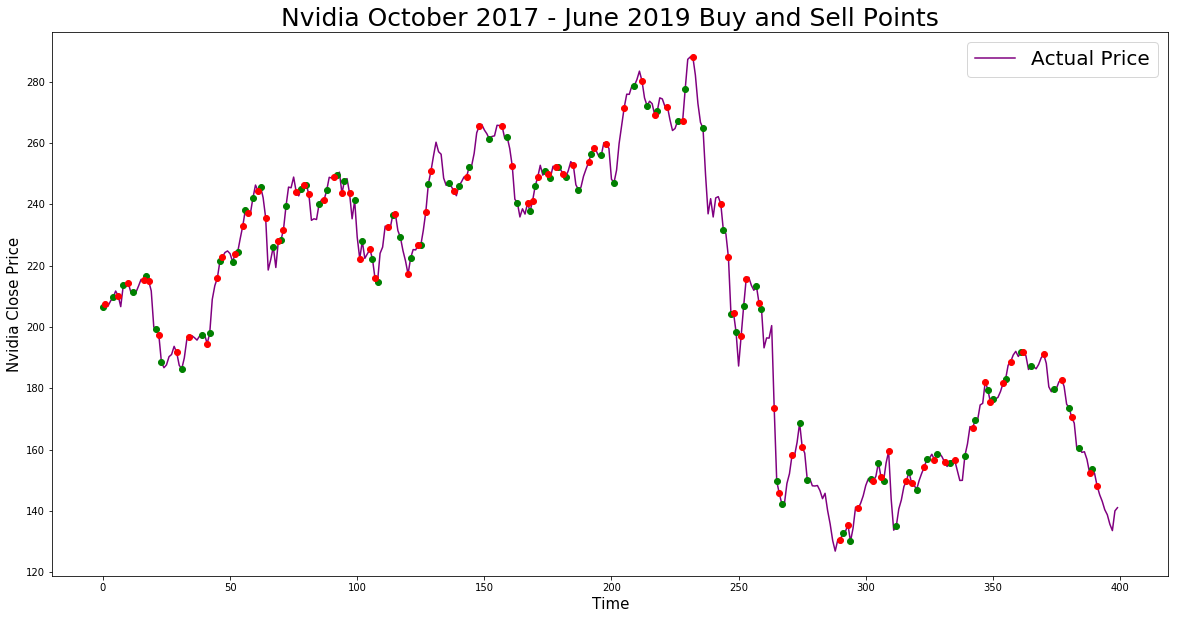

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(20,10))
plt.plot(df_backtest_nv["Close"].values, color =  'purple', label = "Actual Price")
#plt.plot(y_pred_out.reshape(-1, 1), color = 'blue', label = "Predicted Price")
plt.plot(BuyPoints[1], BuyPoints[0], "go")
plt.plot(SellPoints[1], SellPoints[0], "ro")

plt.title("Nvidia October 2017 - June 2019 Buy and Sell Points", size=25)
plt.xlabel('Time', size=15)
plt.ylabel('Nvidia Close Price', size=15)
plt.legend(prop={'size': 20})
plt.show()
plt.savefig("/content/gdrive/My Drive/Plots/Nvidia buy-sell points")